CS4445 Human Centric Computing: Bio-Inspired Computing
Template for Assignment Option 1: DQN CartPole Classic Control

This sample code is based on one of the recommended texts. A small number of errors were deliberately injected into the code.

If using this code as a basis for Option 1:
•	Correct the bugs.
•	Comment the code extensively.
•	Replace CartPole with a different Classic Control problem form gym.
•	Generate more informative plots i.e. plot running average.
•	Consider generating an animation.
•	Play around with hyperparameters and parameters to achieve ‘satisfactory’ performance.

A template will NOT be provided for Option 2. Use this template and modify the following (1) shape of obs and actions (2) network structure, (3) storing and processing of experience, etc.

In [1]:
# Provides access to system-specific parameters and functions
import sys
assert sys.version_info >= (3,10)

In [2]:
# Upgrades the ipykernel package to the latest version. Allows for execution of Python code within Jupyter Notebook
%pip install --upgrade ipykernel

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Installs gym with classic control environments
%pip install -q -U gym[classic_control]==0.25.2

# Installs gym with environments requiring acceptance of ROM license
%pip install -q -U gym[accept-rom-license]==0.25.2

# Installs gym with pendulum environments
%pip install -q -U gym[pendulum]==0.25.2

# Library for game development
%pip install pygame

# Library for numerical computation
%pip install numpy

# Library for data visualization
%pip install matplotlib

# Library for machine learning and neural networks
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [77 lines of output]
      
      
      WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
      Using WINDOWS configuration...
      
      Making dir :prebuilt_downloads:
      Downloading... https://www.libsdl.org/release/SDL2-devel-2.0.16-VC.zip 13d952c333f3c2ebe9b7bc0075b4ad2f784e7584
      Unzipping :prebuilt_downloads\SDL2-devel-2.0.16-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_image/release/SDL2_image-devel-2.0.5-VC.zip 137f86474691f4e12e76e07d58d5920c8d844d5b
      Unzipping :prebuilt_downloads\SDL2_image-devel-2.0.5-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_ttf/release/SDL2_ttf-devel-2.0.15-VC.zip 1436df41ebc47ac36e02ec9bda5699e80ff9bd27
      Unzipping :prebuilt_downloads\SDL2_ttf-devel-2.0.15-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_mixer/release/SDL2_mixer-devel-2.0.4-VC.zi

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
# Set the environment variable SDL_VIDEODRIVER to 'dummy' to disable video output for gym
os.environ['SDL_VIDEODRIVER'] = 'dummy'
import gym
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import pygame

In [5]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.15.0")

In [6]:
# Check if TensorFlow is configured to use a GPU for computation.
if not tf.config.list_physical_devices('GPU'):
    print("Get a GPU ......")

Get a GPU ......


In [7]:
# Lists environments in gym alphabetically
envs = gym.envs.registry
sorted(envs.keys())[:10] + ["..."]

['Acrobot-v1',
 'Ant-v2',
 'Ant-v3',
 'Ant-v4',
 'BipedalWalker-v3',
 'BipedalWalkerHardcore-v3',
 'Blackjack-v1',
 'CarRacing-v2',
 'CartPole-v0',
 'CartPole-v1',
 '...']

In [8]:
envs['CartPole-v1']

EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, new_step_api=False, kwargs={}, namespace=None, name='CartPole', version=1)

In [9]:
new_step_API=True
env = gym.make('CartPole-v1', render_mode='rgb_array')

c:\Users\rosie\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\rosie\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [10]:
obs = env.reset(seed=42)
obs

for e in env.step(1):
    print(e)

[ 0.02727336  0.18847767  0.03625453 -0.26141977]
1.0
False
{}


c:\Users\rosie\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [11]:
pygame.init()
pygame.display.list_modes()
env.reset(seed=42)
img = env.render()

In [12]:
tf.random.set_seed(42)

input_shape = [4]
n_outputs = 2

model = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation="sigmoid", input_shape=input_shape),
    tf.keras.layers.Dense(24, activation="sigmoid"),
    tf.keras.layers.Dense(n_outputs)
])

c:\Users\rosie\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() >= epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()

In [14]:
from collections import deque

replay_buffer = deque(maxlen=400)

In [15]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

In [16]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [17]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

In [18]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    min_next_Q_values = next_Q_values.min(axis=1)
    runs = 1.0 - (dones)
    target_Q_values = rewards + runs * discount_factor * min_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [19]:
for episode in range(300):
    obs = env.reset()
    for step in range(200):
        epsilon = 0.5
        obs, reward, done, info  = play_one_step(env,obs, epsilon)
        if done:
            break
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 162, Steps: 15, eps: 0.500

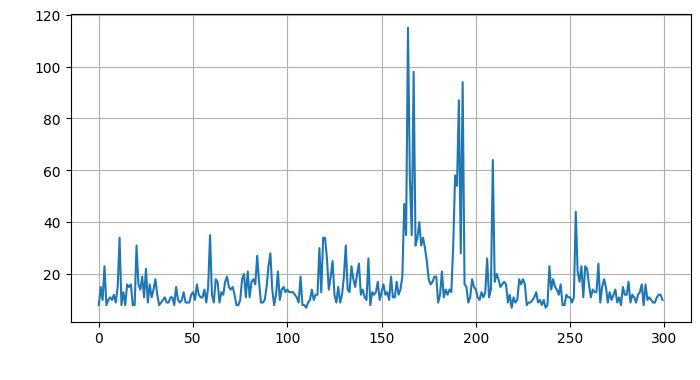

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel(" ", fontsize=14)
plt.ylabel(" ", fontsize=14)
plt.grid(True)
plt.show()